## Exploratory Data Analysis on Embedding Point Clouds

In [63]:
from _collections_abc import Iterable

# File reading and loading
import glob
import re
import json

# Data analysis
import numpy as np
from scipy.spatial.distance import cdist

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [2]:
def parse_json_filename(filename:str) -> tuple[str, list[tuple[str]]]:
    '''
    Parse JSON filesnames produced by CodeEmbeddingsGenerator.py
    into the classes, methods, and tokens they are located in.

    Args:
        filename: JSON filename to parse.
    
    Returns:
        level: Coding level of granularity (i.e., "class", "method", "token")
        identifiers: An ordered list of the nested classes, methods, and/or token.
    '''
    f = filename[:-5]
    nesting = []
    for m in re.finditer(r'(^|_)(c\.|m\.|token)', f):
        if (m.group() == 'c.') or (m.group() == '_c.'): level = 'class'
        elif (m.group() == 'm.') or (m.group() == '_m.'): level = 'method'
        elif (m.group() == 'token') or (m.group() == '_token'): level = 'token'
        else:
            print(f'Something has gone wrong! \n\tFilename: {filename}\n\tMatch: {m}')
            level = ''

        nesting.append((m.start(), m.end(), level))

    identifiers = []
    for i in range(1, len(nesting)):
        end = nesting[i]
        start = nesting[i-1]

        # Get identifier name and duplicate number 
        # (or just duplicate number if its a token)
        name = f[start[1] : end[0]]
        identifiers.append((name, start[2])) # Store name and level

    # Get last name and level
    last = nesting[-1]
    name = f[last[1]:] 
    identifiers.append((name, last[2]))

    # Return embedding level and parsing results
    return last[2], identifiers


def get_embedding_paths(sub_dirs:Iterable[str] = ['data'], 
                        levels:Iterable[str] = ['class', 'method', 'token'],
                        id_nestings:Iterable[tuple[str]] = []
                        ) -> tuple[list[str], list[str]]:
    '''
    Return file paths for JSON files created by CodeEmbeddingsGenerator.py.
    Collects all JSON files in a data folder by default.

    sub_dirs: Paths to subdirectories within the data folder to collect the JSON files from.
    levels: Embedding levels to collect (i.e., "class", "method", "token").
    id_nestings: Ordered lists of classes and/or methods that the code fragments associated with 
        the embeddings must be found in. The format must match that of the the 2nd output of 
        parse_json_filename().

    Returns:
        embed_paths: Paths to the JSON files.
        embed_levels: Embedding levels associated with each path in embed_paths.
    '''
    for level in levels:
        if level not in ('class', 'method', 'token'):
            print(f'Warning: Invalid level name "{level}".')
            
    embed_paths = []
    embed_levels = []
    for dir in sub_dirs:
        # Search through all JSON files
        for path in glob.glob(dir + '/**/*.json', recursive=True):
            filename = re.split(r'\\|/', path)[-1] # Get filename (and file extension)
            level, identifiers = parse_json_filename(filename) # Get embedding level and the nesting
            # Collect paths to embeddings of specified levels
            if level in levels:
                if len(id_nestings) == 0:
                    embed_paths.append(path)
                    embed_levels.append(level)
                    continue
                # Collect paths to embeddings that are nested in the specified classes and/or methods
                for nesting in id_nestings:
                    if nesting == identifiers[:len(nesting)]:
                        embed_paths.append(path)
                        embed_levels.append(level)
                        break
    return embed_paths, embed_levels


def paths_to_data(paths:Iterable[str], to_ndarray:bool = False) -> dict:
    '''
    Takes a list of directory paths to JSON files generated by CodeEmbeddingsGenerator.py, 
    then loads the data and compiles them into a single dictionary.

    Args:
        paths: The list of directory paths to JSON files.

    Returns:
        data: A dataset of embeddings, the associated identifier/token name, 
            the start and end indices for parsing the original code fragment,
            and the directory path to the JSON file.
    '''
    data = {'embeds':list(), 'names':list(), 'spans':list(), 'paths':list()}
    for path in paths:
        file = json.load(open(path, 'r'))
        data['embeds'].append(file[0][0]) # Embedding
        data['names'].append(file[1]) # Identifier or token name
        data['spans'].append(file[2]) # Start and end indices in source code
        data['paths'].append(path) # Path to file

    if to_ndarray:
        # Turn lists into numpy arrays
        for key in data.keys():
            data[key] = np.array(data[key])
    return data

In [3]:
# List of all directories to folders of JSON files
# These are the Java files in the original codebase
java_files = list(set(['\\'.join(dir.split('\\')[:-1]) for dir in glob.glob("data\\**\\*.json", recursive=True)]))

In [182]:
# List of all directories to folders of folders of JSON files
# These are the folders in the original codebase
folders = list(set(['\\'.join(dir.split('\\')[:-1]) for dir in java_files]))

### Class, Method, and Token Total Counts

In [28]:
paths, _ = get_embedding_paths(levels=['class'])
len(paths)

579

In [29]:
paths, _ = get_embedding_paths(levels=['method'])
len(paths)

5352

In [30]:
paths, _ = get_embedding_paths(levels=['token'])
len(paths)

378782

### Location Based on Distance From Origin (0,0,...,0)

In [304]:
def create_data_sets(dirs, levels):
    data_sets = [] # Sets of embeddings taken from their corresponding Java file
    for dir in dirs:
        paths, _ = get_embedding_paths(sub_dirs=[dir], levels=levels)
        data = paths_to_data(paths)

        # If the embedding directory yielded no embeddings, do not append the empty data
        if len(data['embeds']) != 0:
            data_sets.append(data)
    return data_sets


def show_dists_from_origin(embed_sets):
    origin = np.zeros((768)) # All embeddings consist of 768 values

    # Run through every set of embeddings
    dist_sets = []
    for embeds in embed_sets:
        # If there are no embeddings in this set, do not plot anything
        if len(embeds) == 0:
            continue

        dists = cdist(embeds, [origin]).reshape(-1)
        dist_sets.append(dists)
    fig = plt.hist(dist_sets, histtype='step', color=['blue']*len(dist_sets), fill=True, alpha=0.05)

    # Show average of all distances
    avg = np.mean([dist for dists in dist_sets for dist in dists])
    plt.axvline(avg, color='k', linestyle='dashed', linewidth=1)
    return fig

In [90]:
# Get class embeddings by the Java files from which they're derived
class_datasets = create_data_sets(dirs=java_files, levels=['class'])

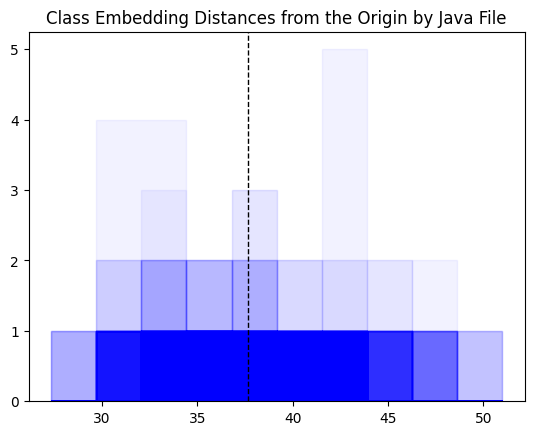

In [305]:
show_dists_from_origin([data['embeds'] for data in class_datasets])
plt.title("Class Embedding Distances from the Origin by Java File")
plt.show()

In [161]:
# Get method embeddings by the Java files from which they're derived
method_datasets = create_data_sets(dirs=java_files, levels=['method'])

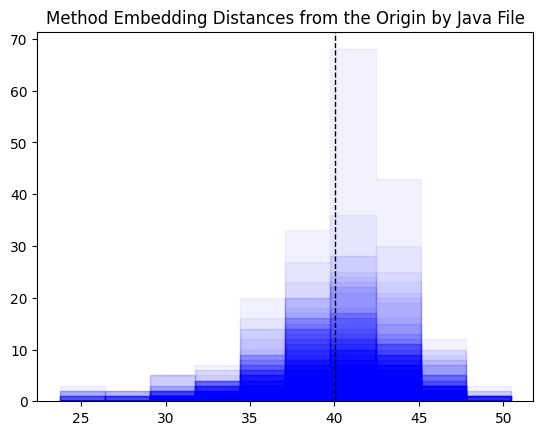

In [306]:
show_dists_from_origin([data['embeds'] for data in method_datasets])
plt.title("Method Embedding Distances from the Origin by Java File")
plt.show()

In [205]:
# Get method embeddings by the immediate directory they're in
folder_sets = []
for dir in folders:
    json_files = glob.glob(dir + '/*//*.json') # JSON files contained in any subsequent folder of the current directory
    java = list(set(['\\'.join(dir.split('\\')[:-1]) for dir in json_files])) # Folders in the current directory immediately containing JSON files 
    folder_sets.append(java)
    
folder_sets[0]

['data\\ivy\\util\\filter\\OrFilter',
 'data\\ivy\\util\\filter\\Filter',
 'data\\ivy\\util\\filter\\AndFilter',
 'data\\ivy\\util\\filter\\FilterHelper',
 'data\\ivy\\util\\filter\\NotFilter',
 'data\\ivy\\util\\filter\\ArtifactTypeFilter',
 'data\\ivy\\util\\filter\\NoFilter']

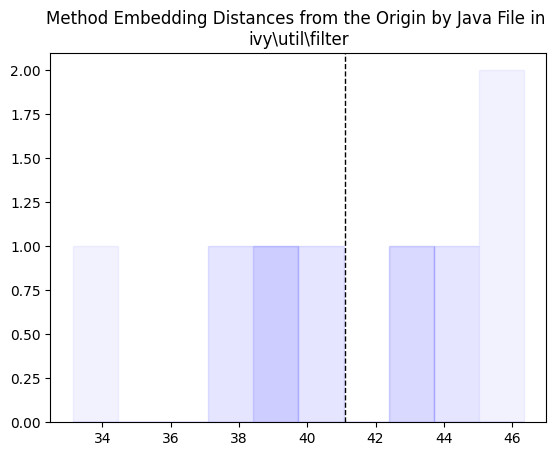

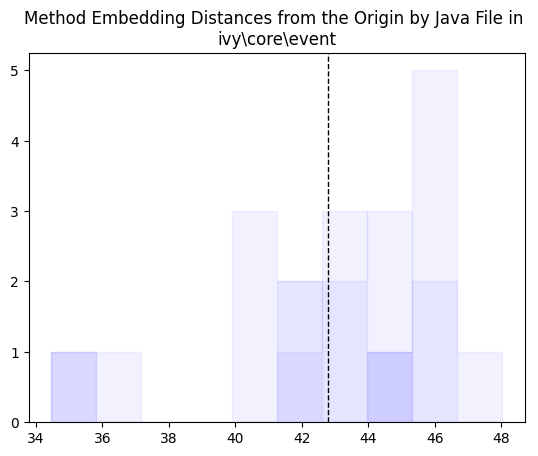

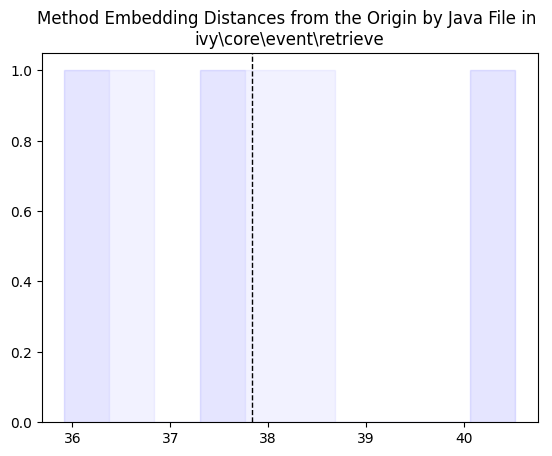

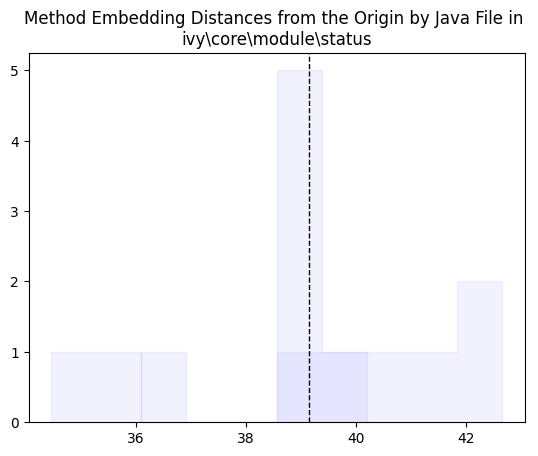

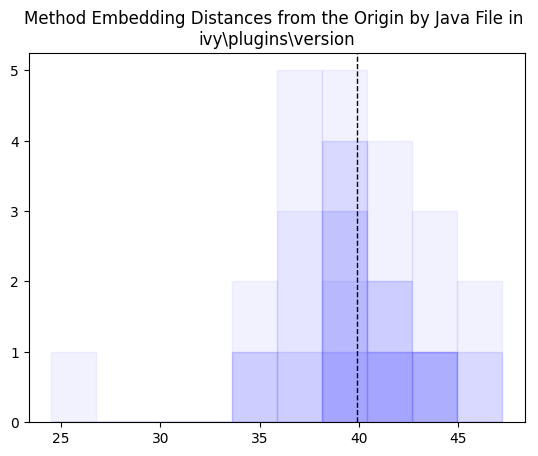

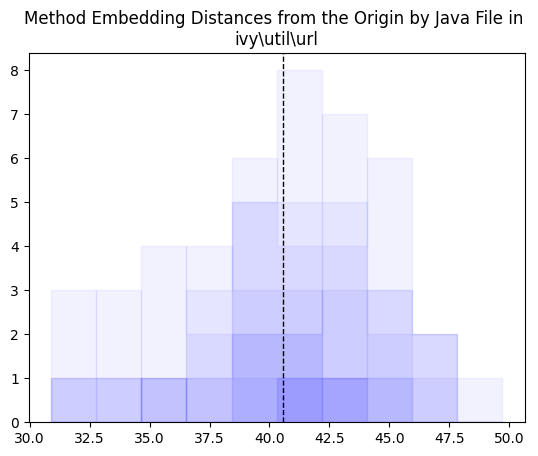

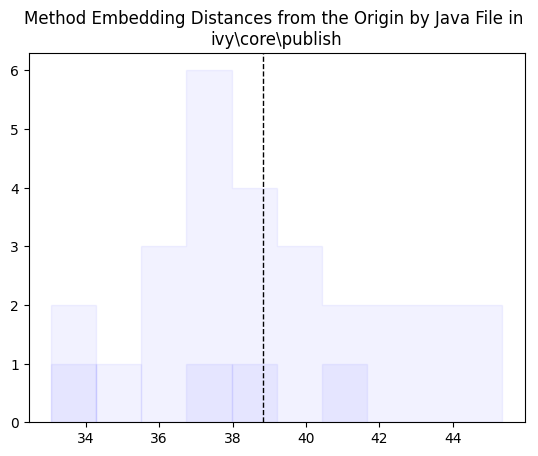

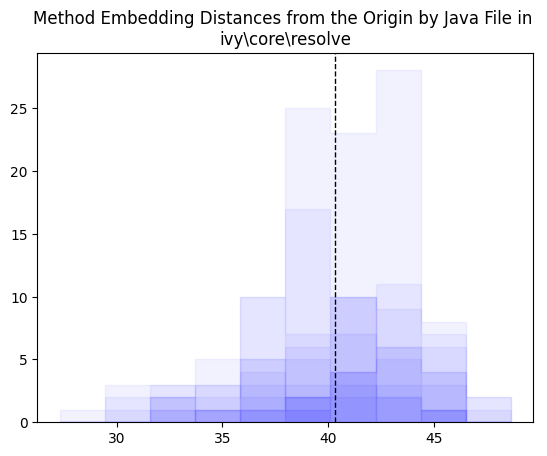

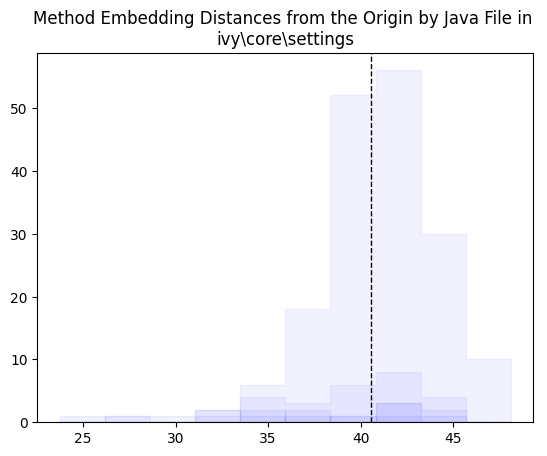

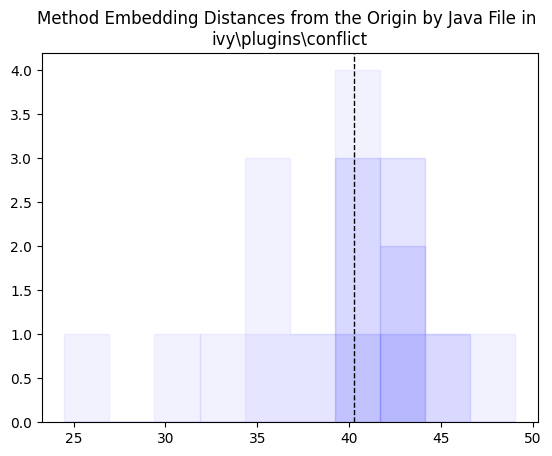

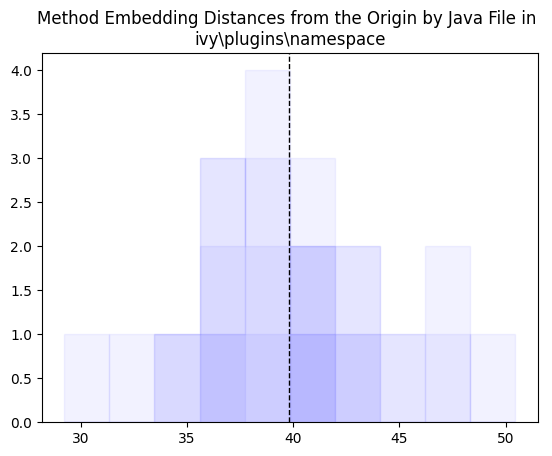

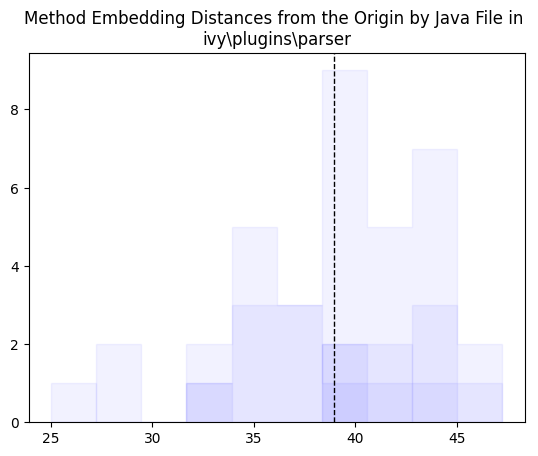

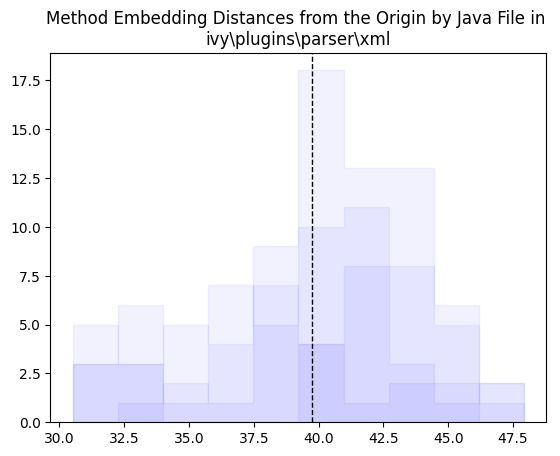

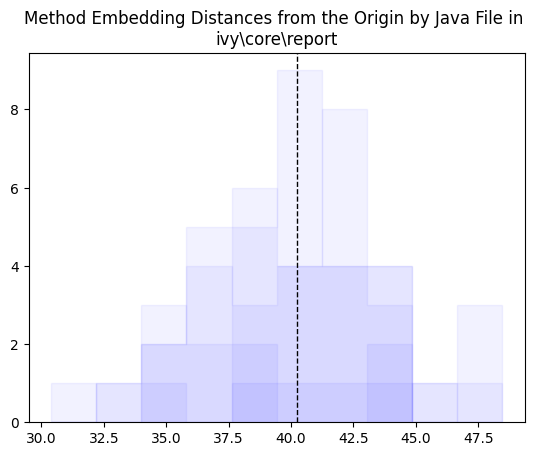

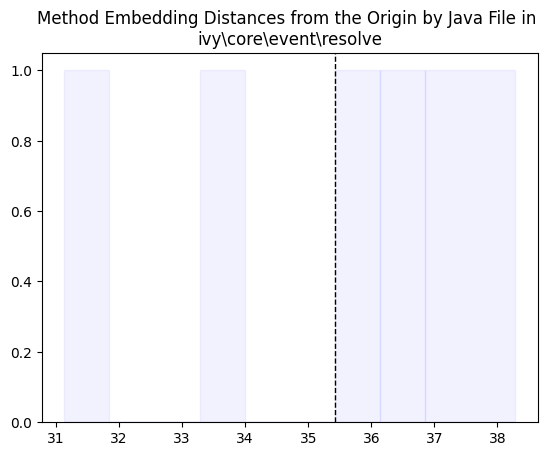

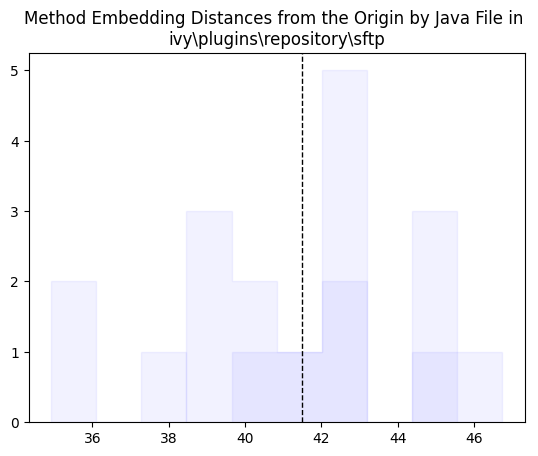

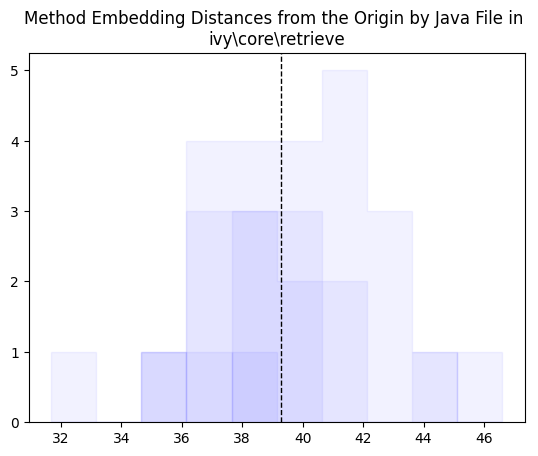

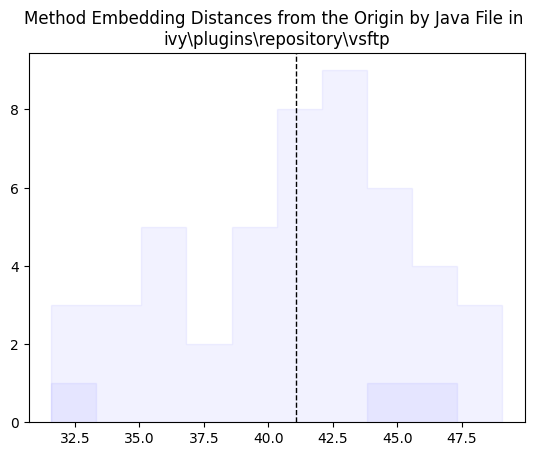

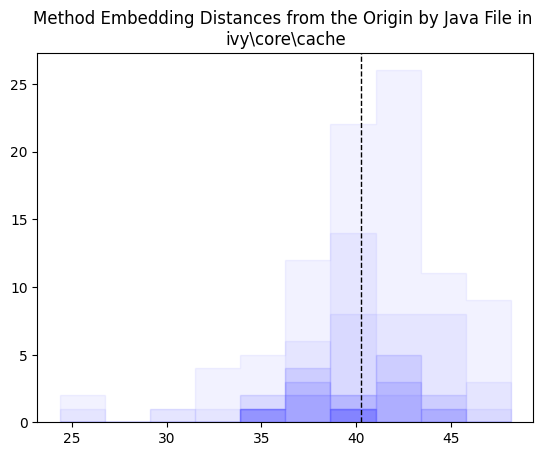

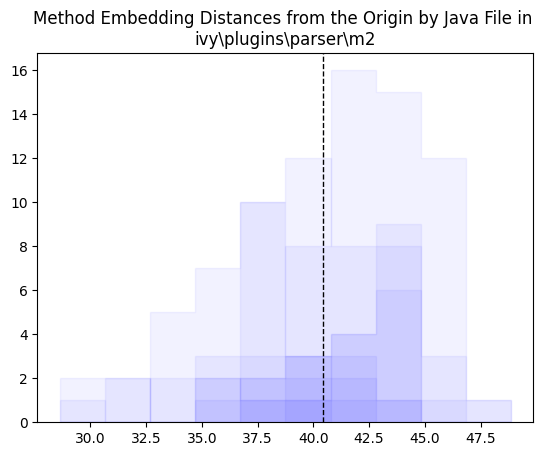

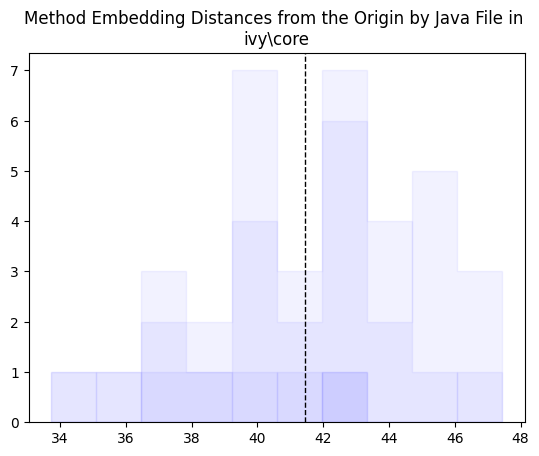

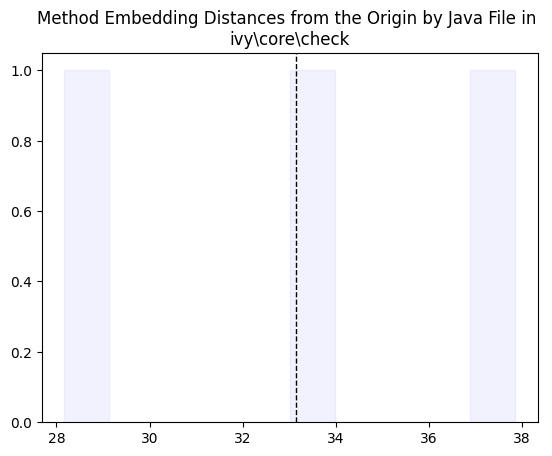

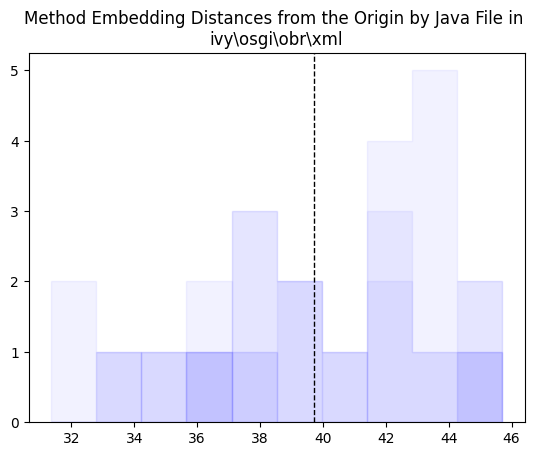

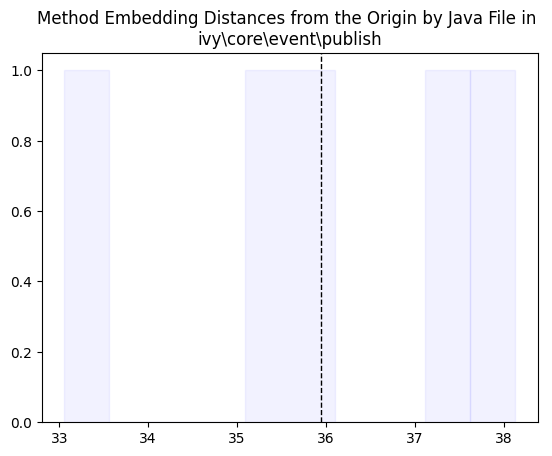

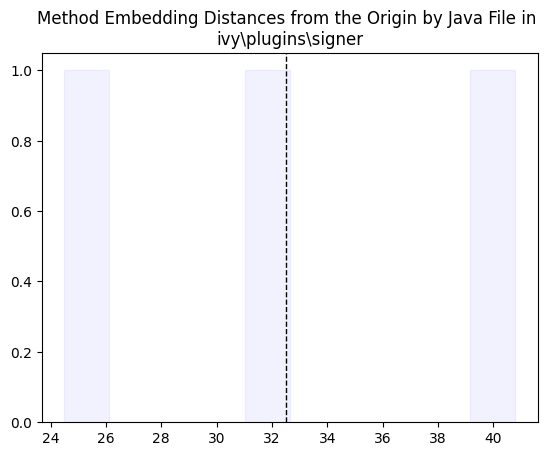

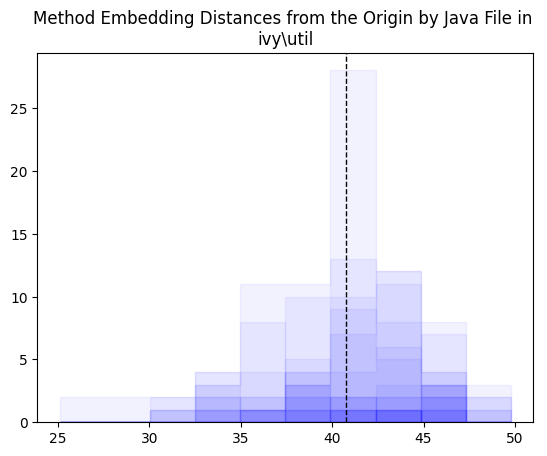

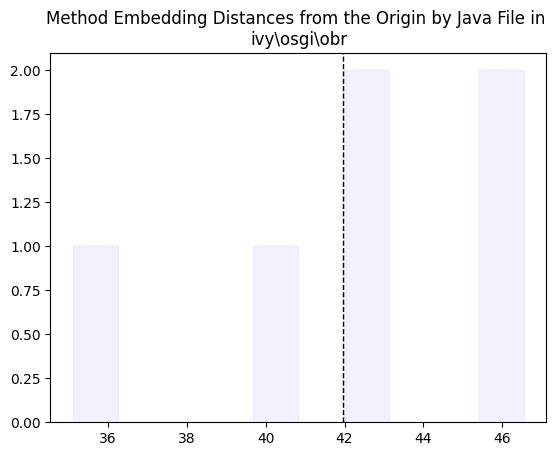

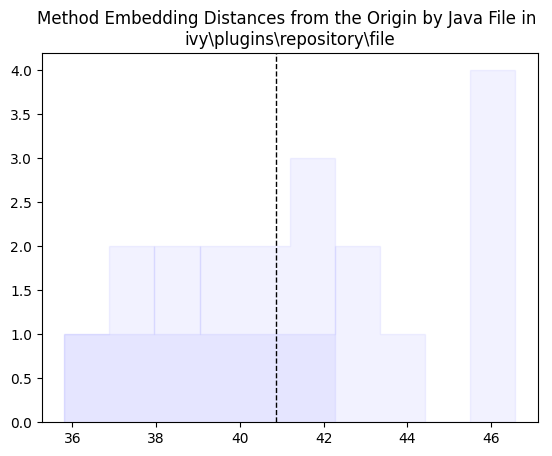

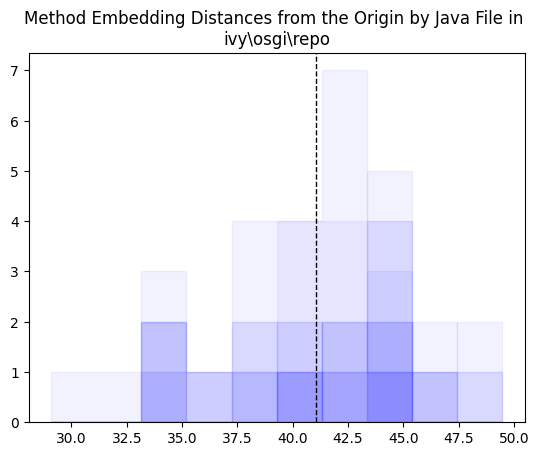

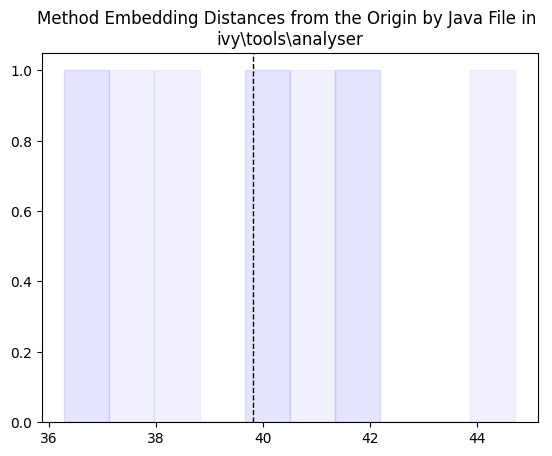

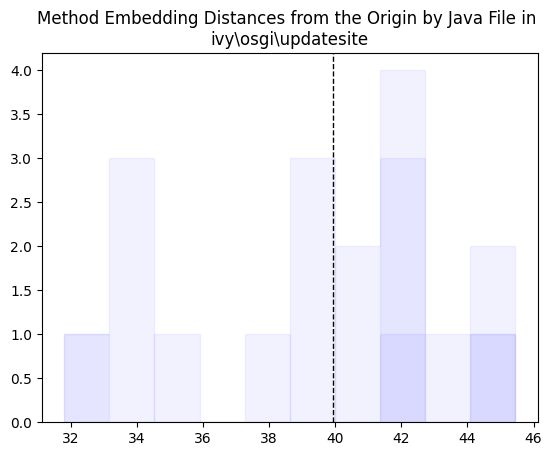

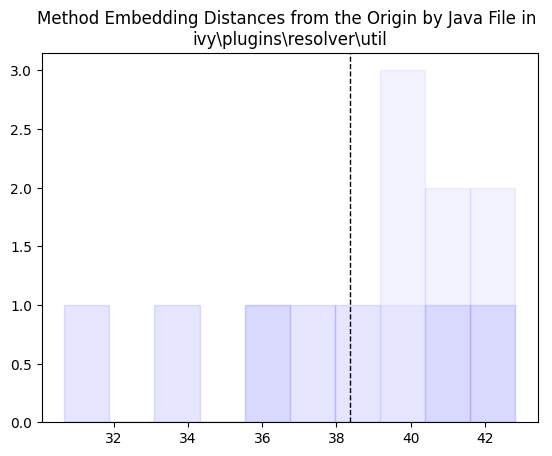

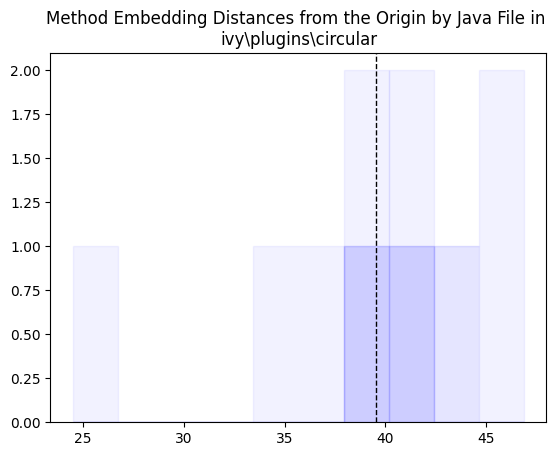

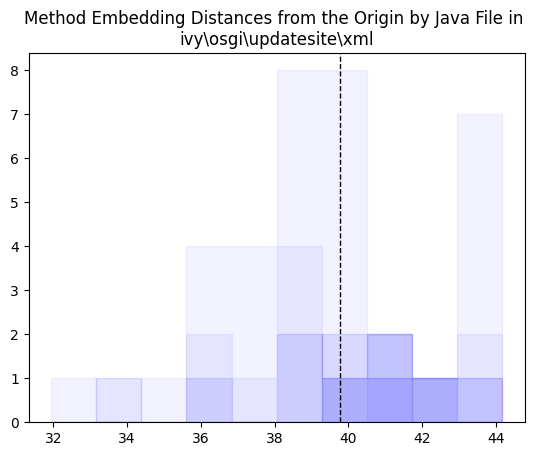

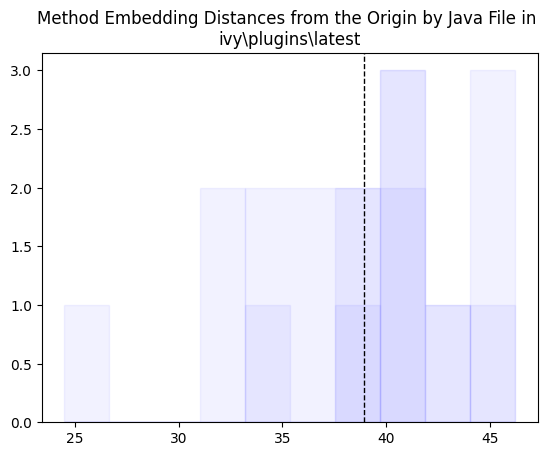

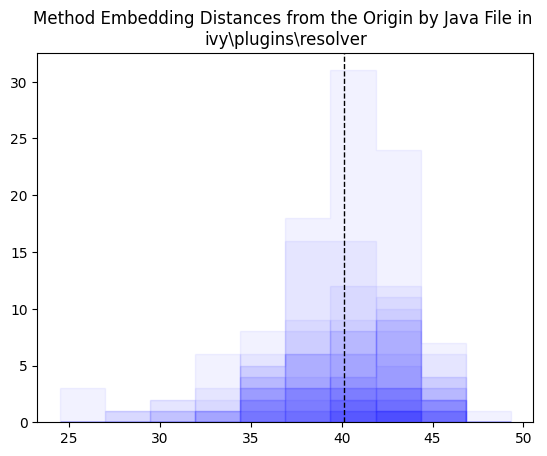

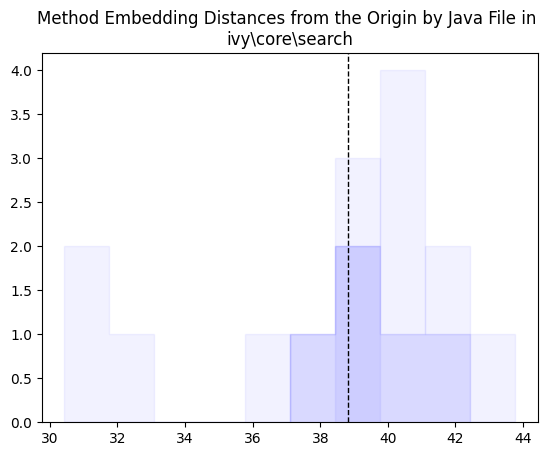

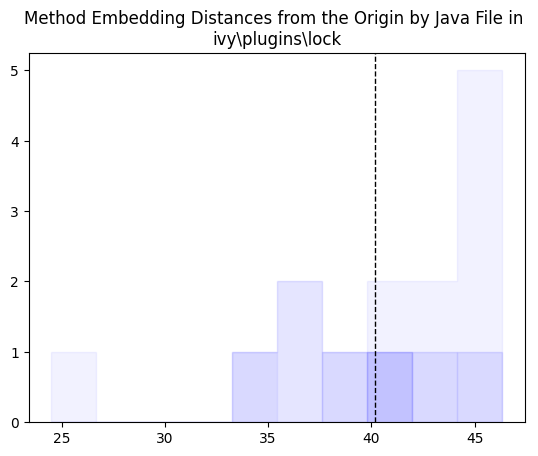

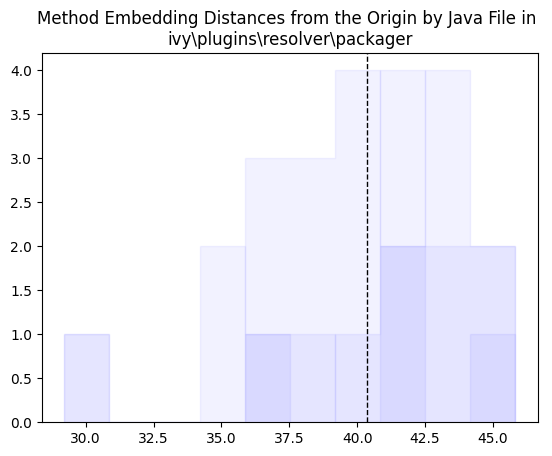

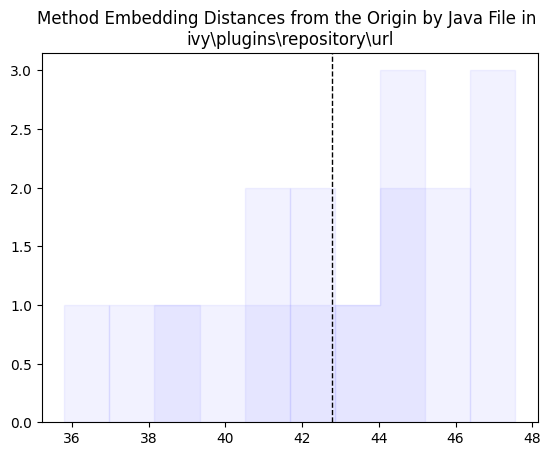

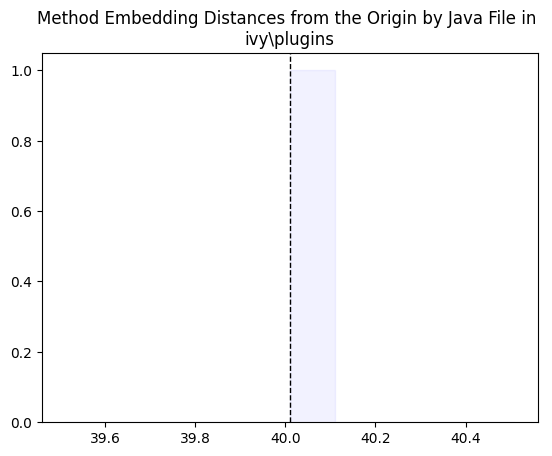

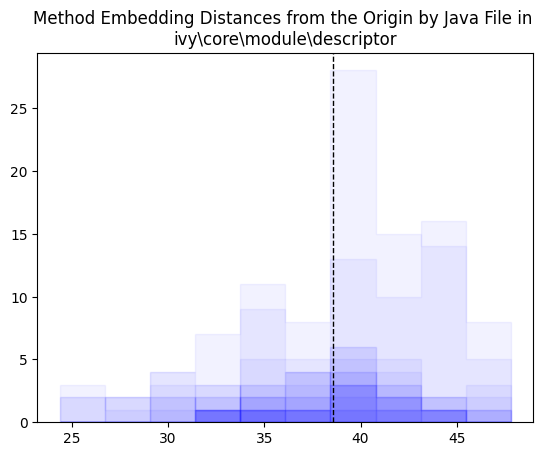

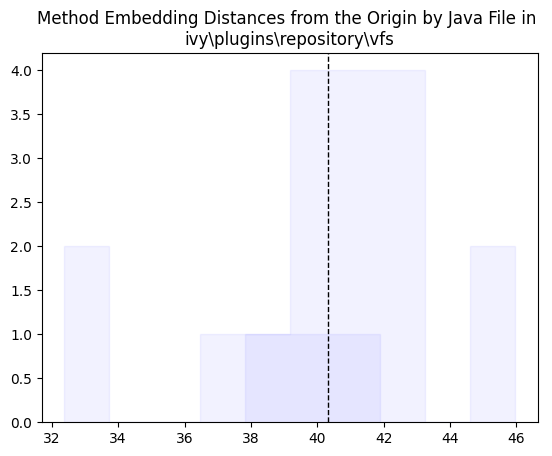

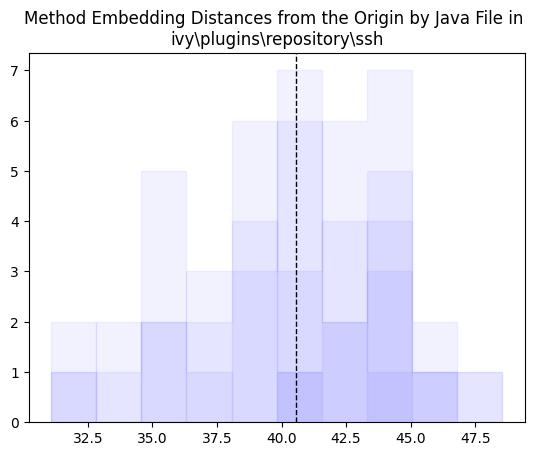

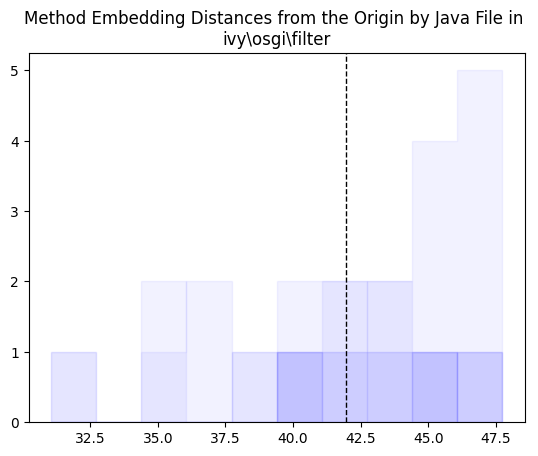

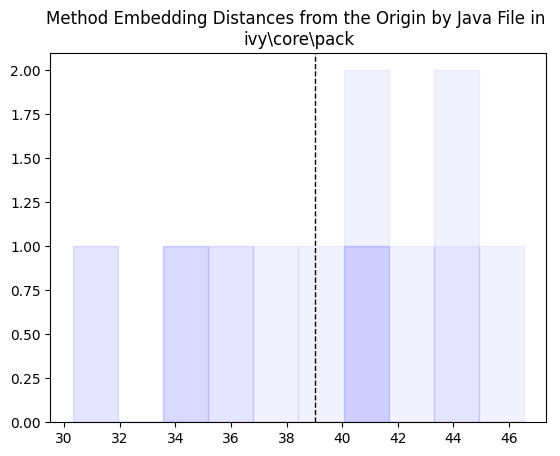

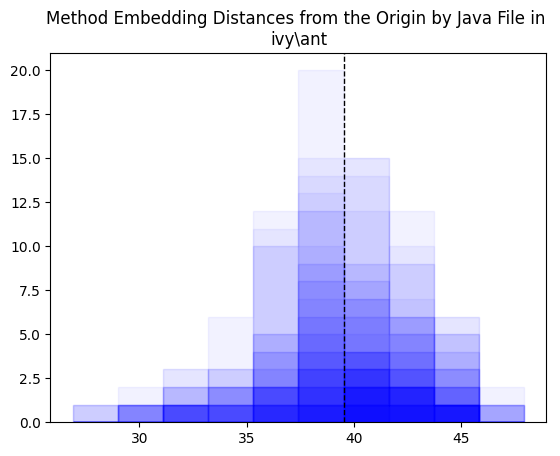

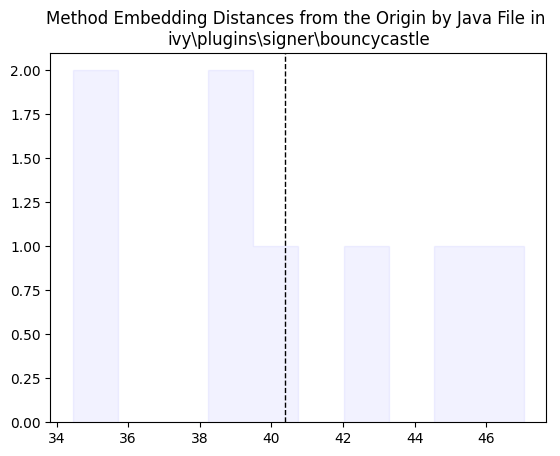

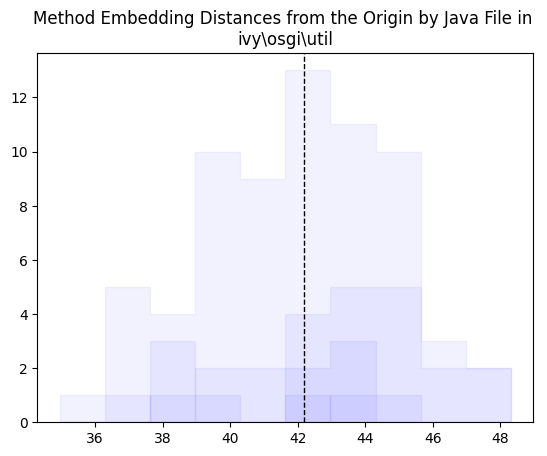

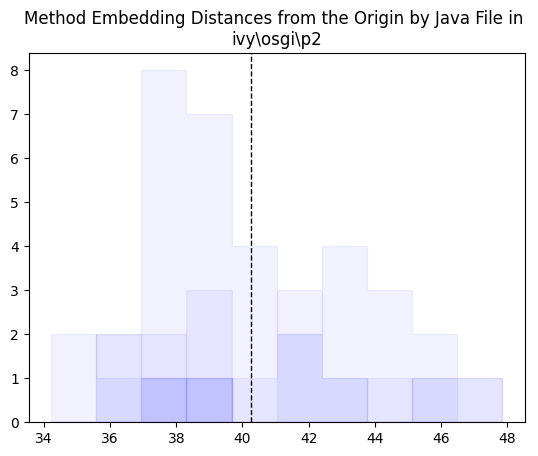

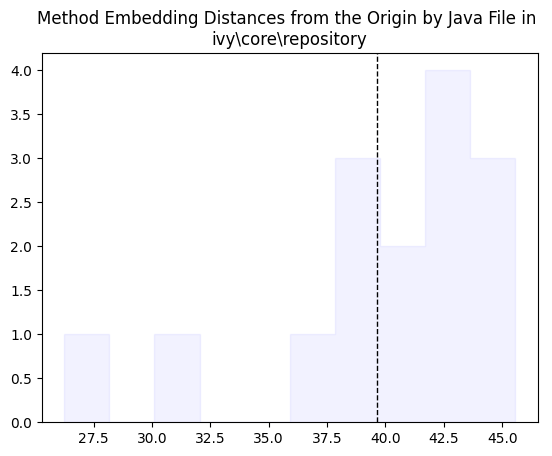

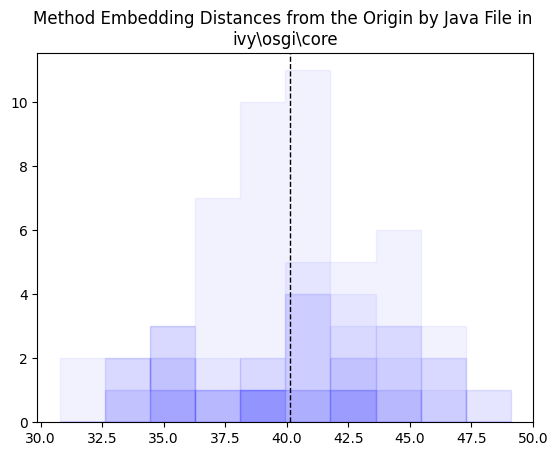

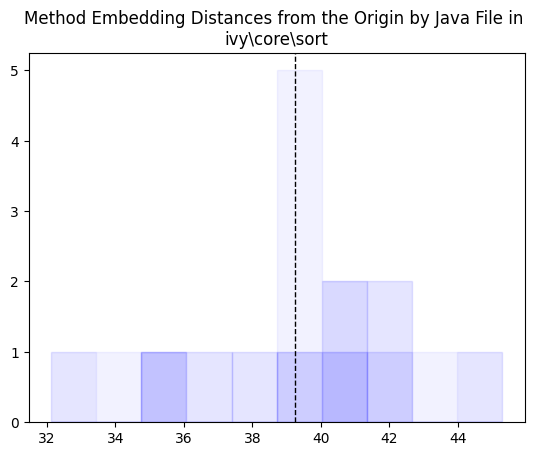

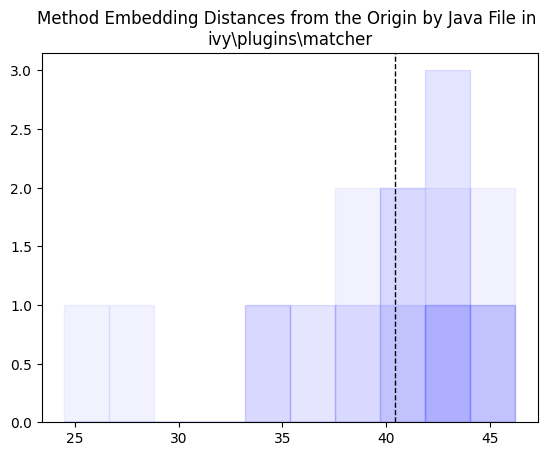

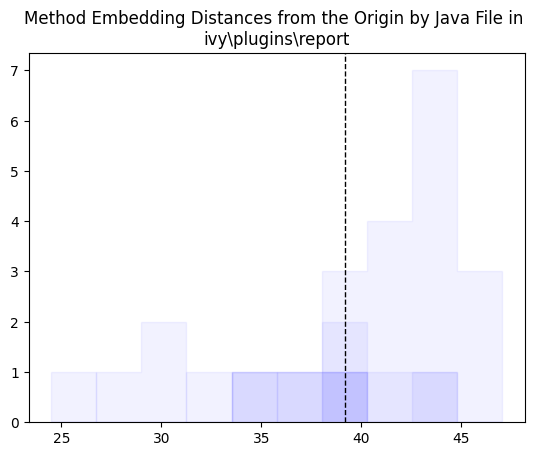

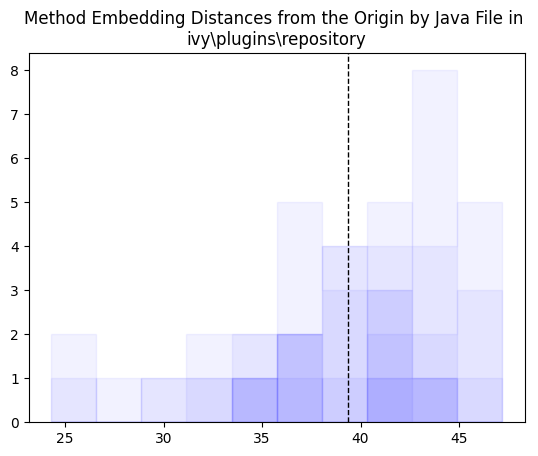

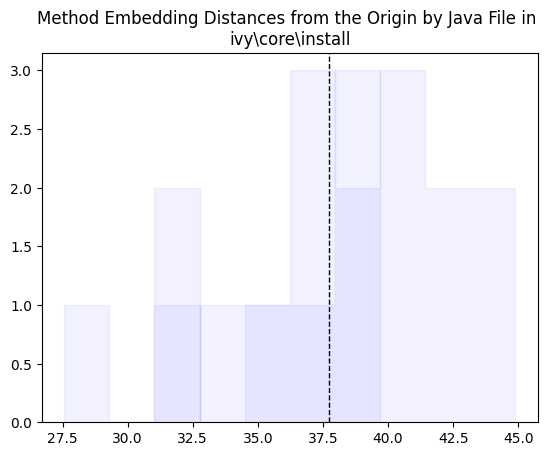

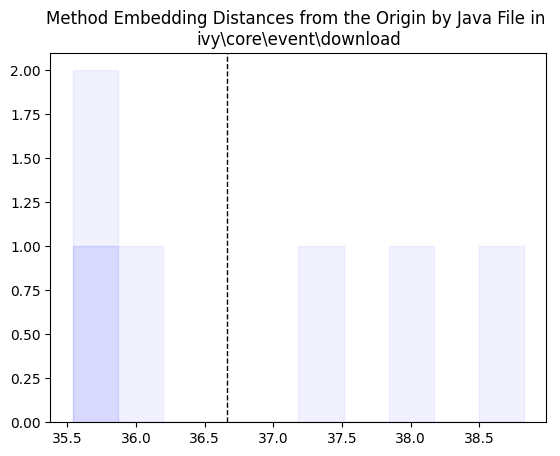

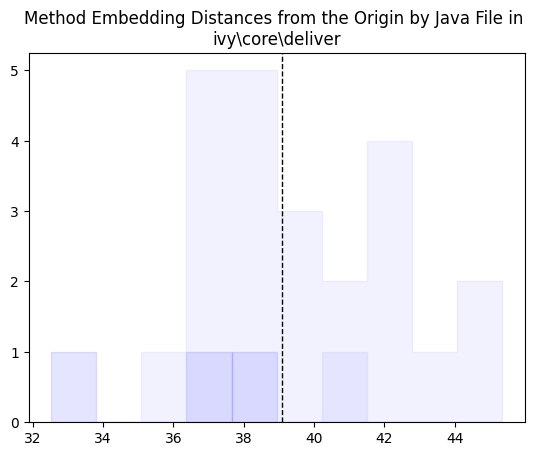

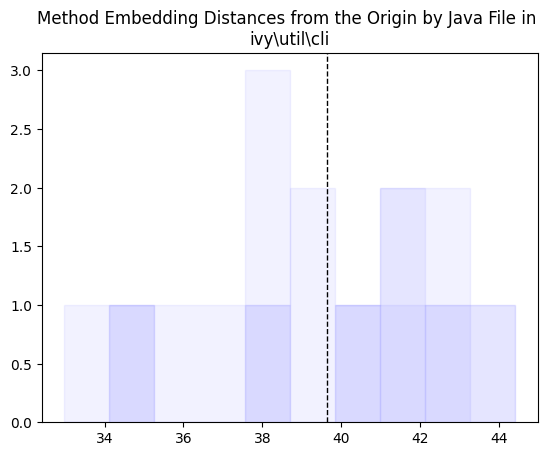

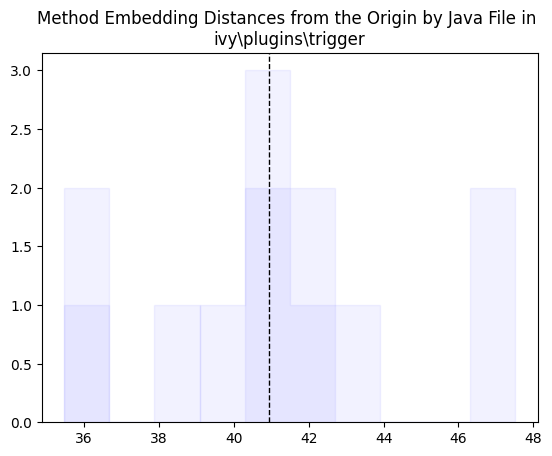

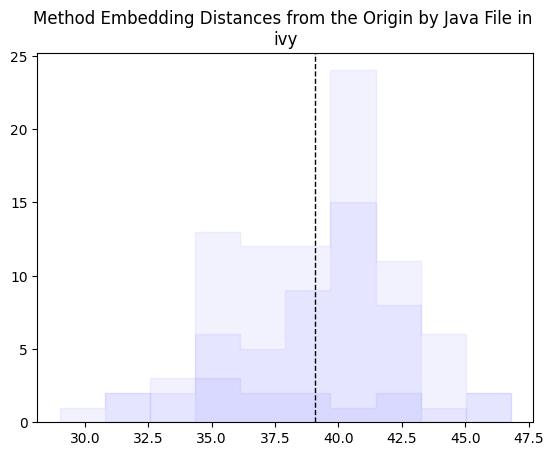

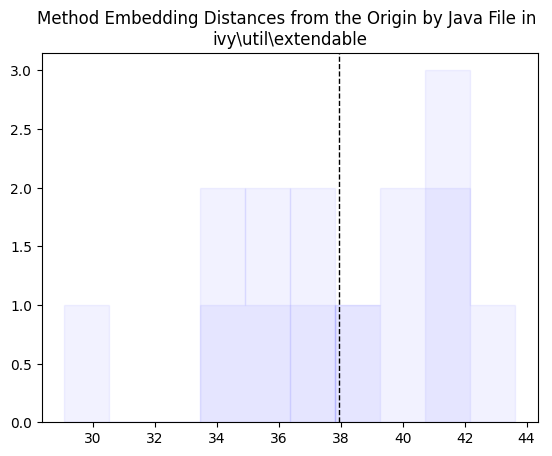

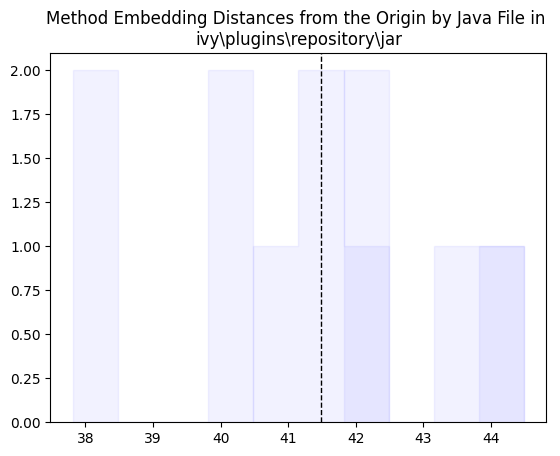

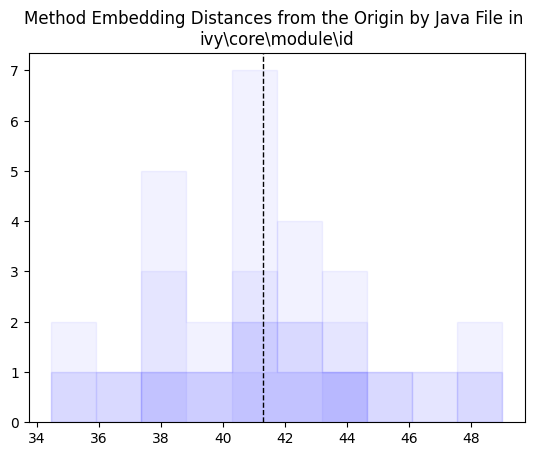

In [ ]:
to_data = 'data'

for i, java in enumerate(folder_sets):
    folder_method_datasets = create_data_sets(dirs=java, levels=['method'])

    show_dists_from_origin([data['embeds'] for data in folder_method_datasets])
    plt.title(f"Method Embedding Distances from the Origin by Java File in \n{folders[i][len(to_data)+1 :]}")
    plt.show()